# Background Model

Here we calculate the background model of Light-1 initially for a specific species and then for a the addition of the species in the atmosphere.

## Single Species

We will calculate the expected number of hits within a time $T$ on the satellite arizing from particle $\chi$. We know the following:

$$\bar{\Phi}_\chi (E) \vcentcolon = \mathbb{E}_\Phi \left[ f_\chi (\Phi, E)\right]$$
$$f_\chi (E) \vcentcolon = \frac{\bar{\Phi}_\chi (E)}{|| \bar{\Phi}_\chi (E) ||}$$

Where $E$ is the energy of the particle, $\Phi$ is the flux of the particle, $f_\chi (\Phi, E)$ is the probability distribution of finding a particular flux of particles $\chi$ with a specific energy $E$ in the atmosphere. 

Notice that we don't actually know the latter distribution, but we won't need to in order to proceed with the background model. All we need is the probability distribution of obtainining a particle with energy $E$ aka $f_\chi (E)$, and the average flux at that particular energy $\bar{\Phi}_\chi (E)$.

We also know that observing a particle is a poisson process. Since we know the expected flux of the particles we can find the probability of obtaining $n$ particles within time $T$ given that they have energy $\varepsilon$.

$$P(N=n \mid E=\varepsilon) = \frac{\lambda(\varepsilon) ^n}{n!} e^{-\lambda(\varepsilon)}$$

Where $\lambda(\varepsilon)$ is the expected rate of events given by

$$\lambda(\varepsilon) = \bar{\Phi}_\chi (\varepsilon) A_{\chi}(\varepsilon) T$$

where $A_{\chi}(\varepsilon)$ is the effective cross sectional area of the satellite for particle $\chi$. This depends on the energy as lower energy particles are more likely to not penetrate the outer layers and reach the detector. This parameter can be given by

$$A_\chi (\varepsilon) = A_{\text{cross}} P_{\chi}(\varepsilon)$$

wheere $A_{\text{cross}}$ is the cross sectional area of the detector, and $P_{\chi}(\varepsilon)$ is the probability that a particle $\chi$ with energy $\varepsilon$ will be thermalized in one of the detectors.

Finally the probability of obtaining $n$ events of species $\chi$ regardless of the energy is going to be:

$$P(N=n) = \int_{\mathbb{R}}d\varepsilon\ P(N=n \mid E=\varepsilon)\, f_\chi(\varepsilon)$$

## Calculation

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import interact
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm

%matplotlib widget

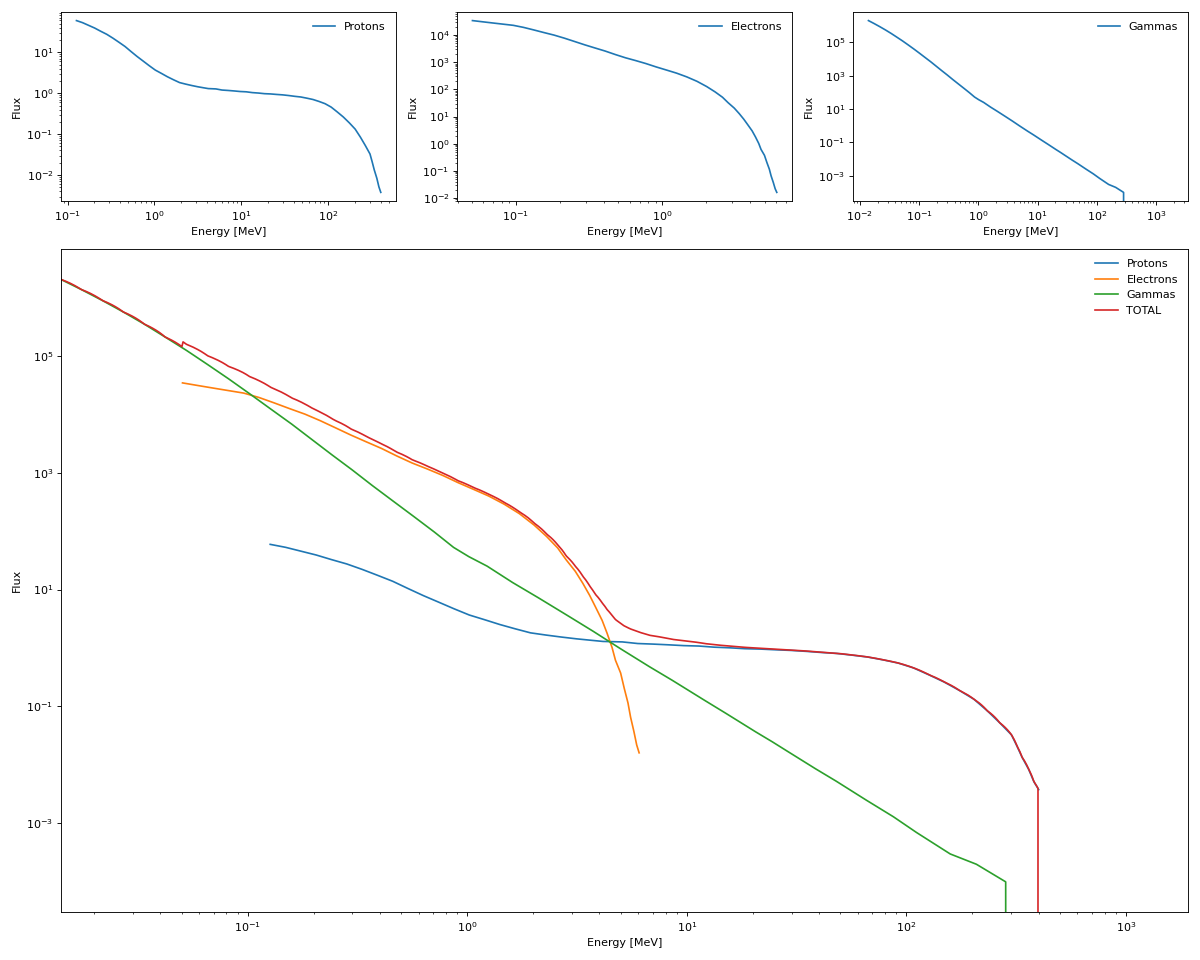

In [2]:
# Load all the data
species = ['Protons','Electrons','Gammas']
labels  = ['energy','flux','distribution','integral']

# Create a dictionary
flux_data = {}

# For all the species
for s in species:
    # Read the data
    full_data = pd.read_csv(f'./data/{s}.csv').to_numpy().T

    # Create a subdictionary
    flux_data[s] = {
        'energy':       full_data[0],
        'flux':         full_data[1],
        'integral':     np.sum(full_data[1][:-1]*(full_data[0][1:] - full_data[0][:-1])),
        'distribution': full_data[1]/np.sum(full_data[1][:-1]*(full_data[0][1:] - full_data[0][:-1]))
    }

# Plot all the distributions
fig     = plt.figure(figsize=(5*len(species),4*3),dpi=80)
axes    = [fig.add_subplot(4,len(species),i) for i in range(1,4)]
main    = fig.add_subplot(4,1,(2,4))
fig.set_tight_layout(tight=True)

# Make the plots
for ax,s in zip(axes,species):
    # Plot the smaller axes
    ax.plot(flux_data[s]['energy'],flux_data[s]['flux'],label=s)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Energy [MeV]')
    ax.set_ylabel('Flux')
    ax.legend(frameon=False)

    main.plot(flux_data[s]['energy'],flux_data[s]['flux'],label=s)

# Create and plot the total flux

# Get a single energy axis
min_energy  = np.min([j for i in [flux_data[s]['energy'] for s in species] for j in i])
max_energy  = np.max([j for i in [flux_data[s]['energy'] for s in species] for j in i])
energy      = np.exp(np.linspace(np.log(min_energy*1.01),np.log(max_energy),1000))
flux_tot    = np.zeros(energy.shape)

# For each species
for s in species:
    # Get the relevant energy subsections
    min_e = np.min(flux_data[s]['energy'])
    max_e = np.max(flux_data[s]['energy'])
    idx = np.where((energy >= min_e) & (energy <= max_e))[0]

    flux_tot[idx] += np.interp(energy[idx],flux_data[s]['energy'],flux_data[s]['flux'])

main.plot(energy, flux_tot,label='TOTAL')

# Prettify
main.set_xlim(min(energy),max(energy))
main.set_xscale('log')
main.set_yscale('log')
main.set_xlabel('Energy [MeV]')
main.set_ylabel('Flux')
main.legend(frameon=False)

In [3]:
# Load the Geant4 Data
geant = {}
for s in species:
    geant_data          = pd.read_csv(f'./data/{s}-geant.txt',sep='*',header='infer')   # Load the data
    geant_data.columns  = geant_data.columns.str.strip()                                # Remove whitespace from the headers
    geant[s]            = geant_data                                                    # Add it on the dictionary

In [4]:
# Get the spectra
geant_spectra = {}

for s in species:
    hist, energy = np.histogram(geant[s]['EdepTOT'],bins=1000, density=True)
    energy = (energy[1:] + energy[:-1])/2

    geant_spectra[s] = {
        'energy':   energy,
        'spectrum':  hist*flux_data[s]['integral'],
        'density':  hist
    }

(0.0112, 14.898763)

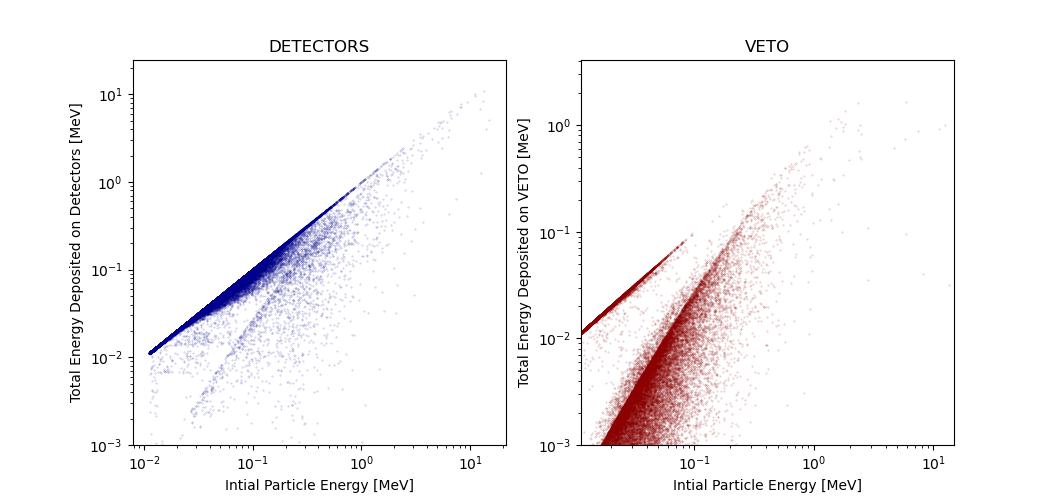

In [5]:
THRESHOLD = 1e-1

sp = species[2]

# Plot the total energy deposited as a function of the total initial energy
fig = plt.figure(figsize=(2*5.3,5))
ax  = [fig.add_subplot(121),fig.add_subplot(122)]
ax[0].scatter(geant[sp]['nrgpri'],geant[sp]['EdepTOT'],s=0.1,alpha=0.3,c='darkblue')
# ax[0].fill_between([min(geant[s]['nrgpri']),max(geant[s]['nrgpri'])],THRESHOLD,alpha=0.3,color='deepskyblue')
ax[0].set_xlabel('Intial Particle Energy [MeV]')
ax[0].set_ylabel('Total Energy Deposited on Detectors [MeV]')
ax[0].set_title('DETECTORS')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylim(1e-3)
# ax[0].set_xlim(min(geant[s]['nrgpri']),max(geant[s]['nrgpri']))

ax[1].scatter(geant[sp]['nrgpri'],geant[sp]['EdepVETO'],s=0.1,alpha=0.3,c='darkred')
# ax[1].fill_between([min(geant[s]['nrgpri']),max(geant[s]['nrgpri'])],THRESHOLD,alpha=0.3,color='deepskyblue')
ax[1].set_xlabel('Intial Particle Energy [MeV]')
ax[1].set_ylabel('Total Energy Deposited on VETO [MeV]')
ax[1].set_title('VETO')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylim(1e-3)
ax[1].set_xlim(min(geant[sp]['nrgpri']),max(geant[sp]['nrgpri']))

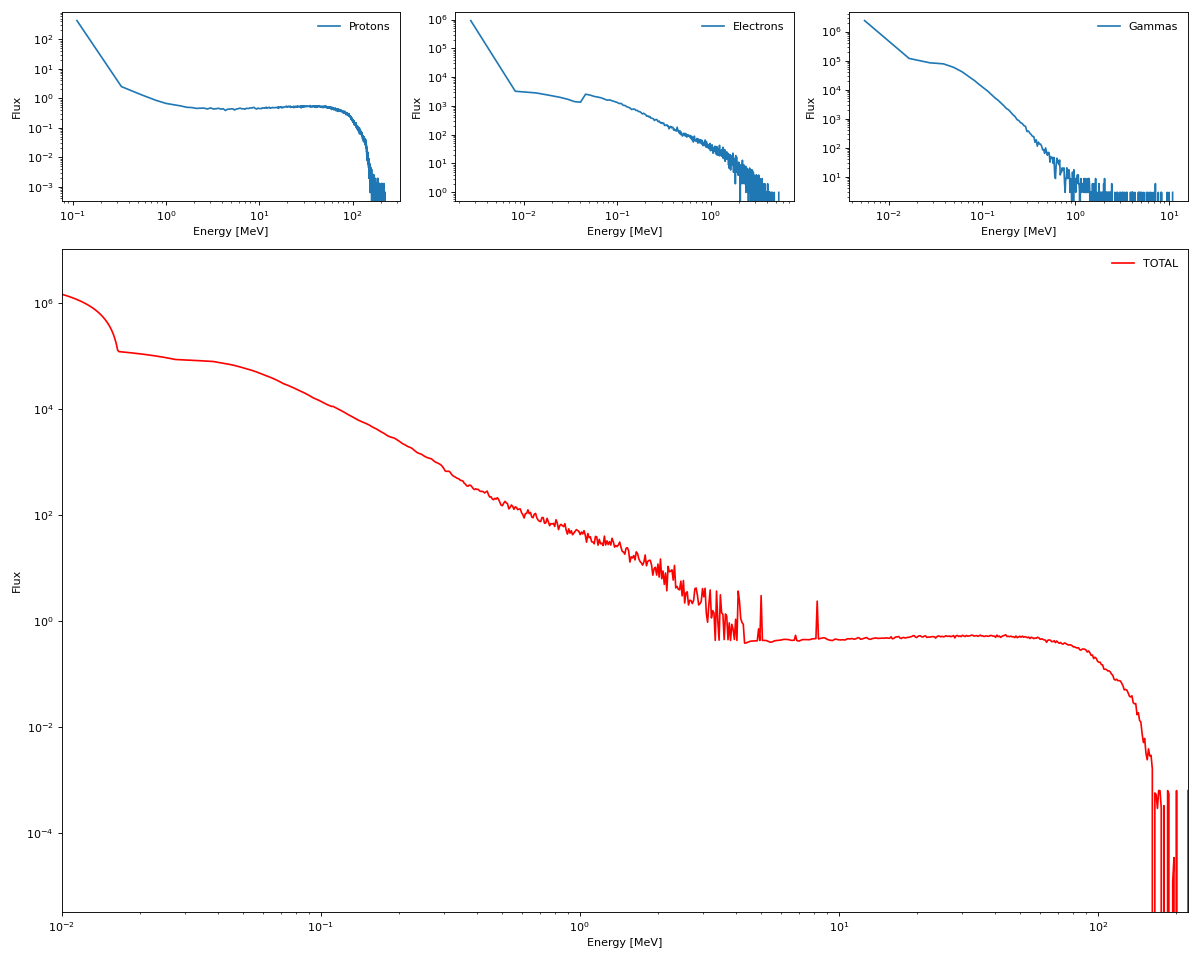

In [6]:
# Load all the data
# Plot all the distributions
fig     = plt.figure(figsize=(5*len(species),4*3),dpi=80)
axes    = [fig.add_subplot(4,len(species),i) for i in range(1,4)]
main    = fig.add_subplot(4,1,(2,4))
fig.set_tight_layout(tight=True)

# Make the plots
for ax,s in zip(axes,species):
    # Plot the smaller axes
    ax.plot(geant_spectra[s]['energy'],geant_spectra[s]['spectrum'],label=s)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Energy [MeV]')
    ax.set_ylabel('Flux')
    ax.legend(frameon=False)

    # main.plot(geant_spectra[s]['energy'],geant_spectra[s]['spectrum'],label=s)

# Create and plot the total flux

# Get a single energy axis
min_energy  = np.min([j for i in [geant_spectra[s]['energy'] for s in species] for j in i])
max_energy  = np.max([j for i in [geant_spectra[s]['energy'] for s in species] for j in i])
energy      = np.exp(np.linspace(np.log(min_energy*1.01),np.log(max_energy),1000))
spec_total  = np.zeros(energy.shape)

# For each species
for s in species:
    # Get the relevant energy subsections
    min_e = np.min(geant_spectra[s]['energy'])
    max_e = np.max(geant_spectra[s]['energy'])
    idx = np.where((energy >= min_e) & (energy <= max_e))[0]

    spec_total[idx] += np.interp(energy[idx],geant_spectra[s]['energy'],geant_spectra[s]['spectrum'])

main.plot(energy, spec_total,label='TOTAL',c='red')

# Prettify
main.set_xlim(min(energy),max(energy))
main.set_xscale('log')
main.set_yscale('log')
main.set_xlabel('Energy [MeV]')
main.set_ylabel('Flux')
main.set_xlim(1e-2)
main.legend(frameon=False)

# SPENVIS
First load the spenvis data along the golden month orbit

In [7]:
## The data file
data_file_p = './Atmospheric_Spectra_SPENVIS/SPECTRA/spenvis_trapped_proton_spectra_orbit.txt'
data_file_e = './Atmospheric_Spectra_SPENVIS/SPECTRA/spenvis_trapped_electron_spectra_orbit.txt'
orbit_file  = './Atmospheric_Spectra_SPENVIS/INPUT_DATA/spenvis_orbit_positions.txt'

# Load the orbit data
def read_orbit_file(data_file:str):
    ## Read the header
    file        = open(data_file,'r')
    lines       = file.readlines()
    file.close()

    ## Extract the spectra for each trajectory point
    header      = [x.strip() for x in lines[0].split(',')]
    start_from  = int(header[1])
    data        = np.array([[float(x.strip()) for x in line.split(',')] for line in lines[start_from:-1]])
    
    return data


def read_flux_file(data_file:str):
    ## Read the header
    file        = open(data_file,'r')
    lines       = file.readlines()
    file.close()

    ## Extract the spectra for each trajectory point
    header      = [x.strip() for x in lines[0].split(',')]
    start_from  = int(header[1])
    data        = np.array([[float(x.strip()) for x in line.split(',')[2:]] for line in lines[start_from:-1]])

    # Extract the energy
    energies = []
    for line in lines:
        if "'ENERGY'" in line: 
            energies = np.array([float(x.strip()) for x in line.split(',')[2:-1]])
            break
    
    return data,energies

# Plot the spectra on one axis
def plot_lines(ax,data,energies,**kwargs):
    for spectra in data:
        if np.sum(spectra>0):
            plot_spectra = spectra.copy()
            plot_spectra[np.where(spectra==0)] = None
            ax.plot(energies,plot_spectra,**kwargs)


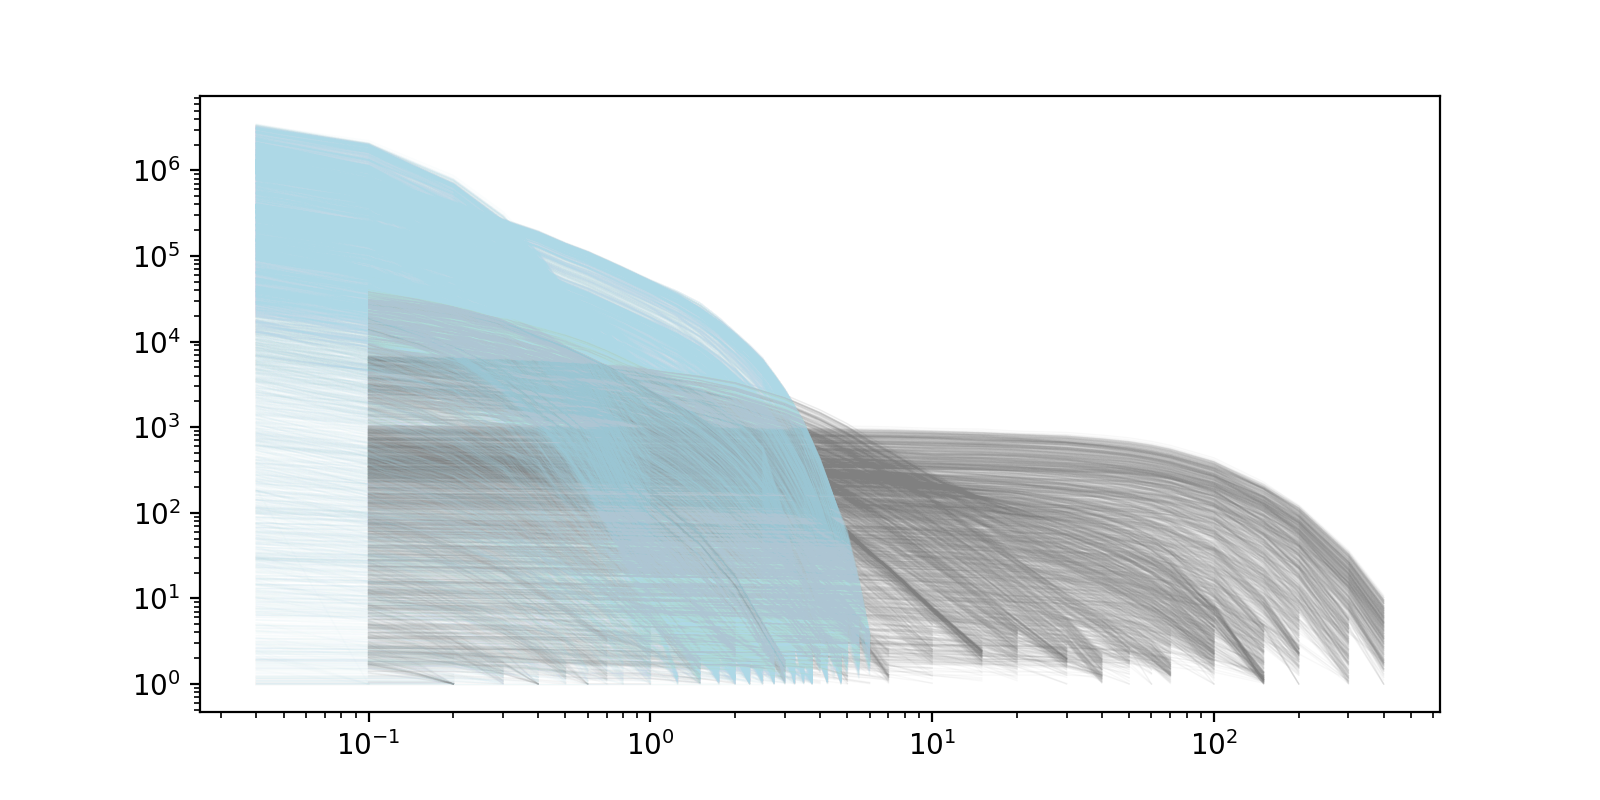

In [8]:
# Create a plot
fig = plt.figure(figsize=(8,4),dpi=200)
ax  = fig.add_subplot(111)

# Add the line 
for file,color in zip([data_file_p,data_file_e],['grey','lightblue']):
    plot_lines(ax,*read_flux_file(file),c=color,lw=0.5,alpha=0.05)

# Style the plot
ax.set_yscale('log')
ax.set_xscale('log')

In [9]:
# Read the data files
protons, energies_p     = read_flux_file(data_file_p)
idx_protons             = [i for i,x in enumerate(protons) if np.sum(x!=0)]
electrons, energies_e   = read_flux_file(data_file_e)
idx_electrons           = [i for i,x in enumerate(electrons) if np.sum(x!=0)]
orbit                   = read_orbit_file(orbit_file)

# Model
model = lambda E,A,B,C: -A*np.exp(-B*E) + C

In [27]:
def get_fit_params(particle, idx, energies):
    # Save the cumulative probability distribution files
    parameters = []
    for index in tqdm(idx):
        # Create the cumulative sum and normalize
        cumsum = np.cumsum(particle[index])
        cumsum = (cumsum - min(cumsum))/(max(cumsum) - min(cumsum))

        # Fit the distribution
        try:
            popt, pcov = curve_fit(model,energies,cumsum)
        except RuntimeError:
            print(f"Can't find optimal fit, skipping entry {index}")
            continue

        # save the parameters
        params = [index,*popt]
        parameters.append(params)

    return parameters
    

# Save them as a csv
out_filename_p  = './Atmospheric_Spectra_SPENVIS/SPECTRA/orbital_proton_spectra_inverse_fit.csv'
parameters_p    = get_fit_params(protons,idx_protons,energies_p)
np.savetxt(out_filename_p,parameters_p,delimiter=',',header=f'{len(parameters_p)}, Index, A, B, C')

out_filename_e = './Atmospheric_Spectra_SPENVIS/SPECTRA/orbital_electron_spectra_inverse_fit.csv'
parameters_e    = get_fit_params(electrons,idx_electrons,energies_e)
np.savetxt(out_filename_e,parameters_e,delimiter=',',header=f'{len(parameters_e)}, Index, A, B, C')

  0%|          | 0/4138 [00:00<?, ?it/s]

  0%|          | 0/6482 [00:00<?, ?it/s]

Can't find optimal fit, skipping entry 14313
Can't find optimal fit, skipping entry 15512
Can't find optimal fit, skipping entry 20577
Can't find optimal fit, skipping entry 23941
Can't find optimal fit, skipping entry 28247
Can't find optimal fit, skipping entry 32552
Can't find optimal fit, skipping entry 38004


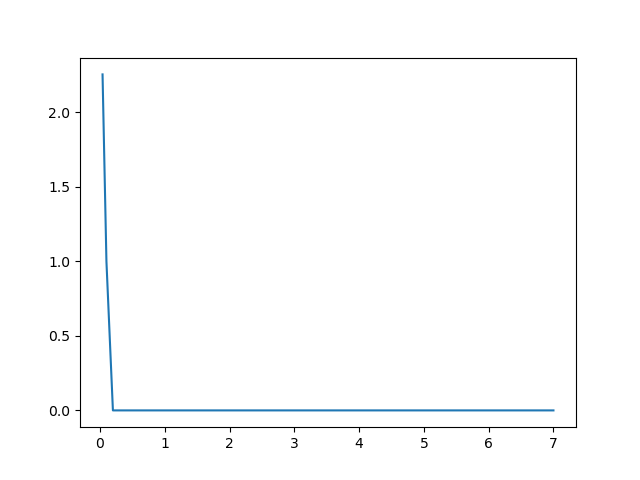

In [34]:
plt.figure()
plt.plot(energies_e, electrons[38004])